# UNSW-NB15 dataset
The dataset is split into 4 files. 
1. UNSW-NB15_1.csv starts from 2015-01-22 11:49:37 until 2015-01-22 19:44:02
2. UNSW-NB15_2.csv starts from 2015-01-22 19:43:15 until 2015-02-18 03:45:29, with gap in between
3. UNSW-NB15_3.csv starts from 2015-02-18 03:44:59 until 2015-02-18 09:00:09
4. UNSW-NB15_4.csv starts from 2015-02-18 08:59:44 until 2015-02-18 12:21:08

Since there's a big time gap in UNSW-NB15_2.csv, for the purpose of prelimnary EDA, we will only use _3 and _4 for now.

In [1]:
import numpy as np
import pandas as pd
import umap
import kmapper as km
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import TakensEmbedding
from kmapper import Cover
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn import ensemble
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors

def load_and_prep_data():
    path = './data'

    # testing_set = pd.read_csv(f'{path}/UNSW_NB15_testing-set.csv')
    # training_set = pd.read_csv(f'{path}/UNSW_NB15_training-set.csv')
    # LIST_EVENTS = pd.read_csv(f'{path}/UNSW-NB15_LIST_EVENTS.csv')
    # GT = pd.read_csv(f'{path}/NUSW-NB15_GT.csv')

    # NB15_1 = pd.read_csv(f'{path}/UNSW-NB15_1.csv')
    # NB15_2 = pd.read_csv(f'{path}/UNSW-NB15_2.csv')
    NB15_3 = pd.read_csv(f'{path}/UNSW-NB15_3.csv')
    NB15_4 = pd.read_csv(f'{path}/UNSW-NB15_4.csv')
    NB15_features = pd.read_csv(f'{path}/NUSW-NB15_features.csv', encoding='cp1252')

    # NB15_1.columns = NB15_features['Name']
    # NB15_2.columns = NB15_features['Name']
    NB15_3.columns = NB15_features['Name']
    NB15_4.columns = NB15_features['Name']

    df = pd.concat([
        # NB15_1,
        # NB15_2,
        NB15_3,
        NB15_4
    ], ignore_index=False)

    df['Timestamp'] = pd.to_datetime(df['Stime'], unit='s')
    df.set_index('Timestamp', inplace=True)
    df.sort_index(inplace=True)

    return df

df = load_and_prep_data()
print(df.iloc[0].name)
print(df.iloc[-1].name)

2015-02-18 03:44:59
2015-02-18 12:21:08


| No. | Name               | Description                                                                                      |
|-----|--------------------|--------------------------------------------------------------------------------------------------|
| 1   | srcip              | Source IP address                                                                                |
| 2   | sport              | Source port number                                                                               |
| 3   | dstip              | Destination IP address                                                                           |
| 4   | dsport             | Destination port number                                                                          |
| 5   | proto              | Transaction protocol                                                                             |
| 6   | state              | Indicates the state and its dependent protocol (e.g., ACC, CLO, CON, etc.)                      |
| 7   | dur                | Record total duration                                                                            |
| 8   | sbytes             | Source to destination transaction bytes                                                          |
| 9   | dbytes             | Destination to source transaction bytes                                                          |
| 10  | sttl               | Source to destination time to live value                                                         |
| 11  | dttl               | Destination to source time to live value                                                         |
| 12  | sloss              | Source packets retransmitted or dropped                                                          |
| 13  | dloss              | Destination packets retransmitted or dropped                                                     |
| 14  | service            | Service type (e.g., http, ftp, smtp, ssh, dns, etc.)                                             |
| 15  | Sload              | Source bits per second                                                                           |
| 16  | Dload              | Destination bits per second                                                                      |
| 17  | Spkts              | Source to destination packet count                                                               |
| 18  | Dpkts              | Destination to source packet count                                                               |
| 19  | swin               | Source TCP window advertisement value                                                            |
| 20  | dwin               | Destination TCP window advertisement value                                                       |
| 21  | stcpb              | Source TCP base sequence number                                                                  |
| 22  | dtcpb              | Destination TCP base sequence number                                                             |
| 23  | smeansz            | Mean of the flow packet size transmitted by the source                                           |
| 24  | dmeansz            | Mean of the flow packet size transmitted by the destination                                      |
| 25  | trans_depth        | Pipelined depth into the connection of HTTP request/response transaction                         |
| 26  | res_bdy_len        | Actual uncompressed content size of the data transferred from the server’s HTTP service         |
| 27  | Sjit               | Source jitter (mSec)                                                                             |
| 28  | Djit               | Destination jitter (mSec)                                                                        |
| 29  | Stime              | Record start time                                                                                |
| 30  | Ltime              | Record last time                                                                                 |
| 31  | Sintpkt            | Source interpacket arrival time (mSec)                                                           |
| 32  | Dintpkt            | Destination interpacket arrival time (mSec)                                                      |
| 33  | tcprtt             | TCP connection setup round-trip time (SYN-ACK + ACK-DAT)                                         |
| 34  | synack             | Time between SYN and SYN-ACK packets                                                             |
| 35  | ackdat             | Time between SYN-ACK and ACK packets                                                             |
| 36  | is_sm_ips_ports    | 1 if source and destination IPs and ports are equal, else 0                                      |
| 37  | ct_state_ttl       | Count of each state based on TTL values                                                          |
| 38  | ct_flw_http_mthd   | Number of flows with HTTP methods like GET and POST                                              |
| 39  | is_ftp_login       | 1 if FTP session accessed with user and password, else 0                                         |
| 40  | ct_ftp_cmd         | Number of flows with FTP commands                                                                |
| 41  | ct_srv_src         | Connections with same service and source IP in last 100 connections                             |
| 42  | ct_srv_dst         | Connections with same service and destination IP in last 100 connections                        |
| 43  | ct_dst_ltm         | Connections with same destination IP in last 100 connections                                     |
| 44  | ct_src_ltm         | Connections with same source IP in last 100 connections                                          |
| 45  | ct_src_dport_ltm   | Connections with same source IP and destination port in last 100 connections                     |
| 46  | ct_dst_sport_ltm   | Connections with same destination IP and source port in last 100 connections                     |
| 47  | ct_dst_src_ltm     | Connections with same source and destination IPs in last 100 connections                         |
| 48  | attack_cat         | Attack category (e.g., Fuzzers, Analysis, DoS, etc.)                                             |
| 49  | Label              | 0 for normal, 1 for attack                                                                       |

# Initial Data Analysis
Looking at the raw data without transformation

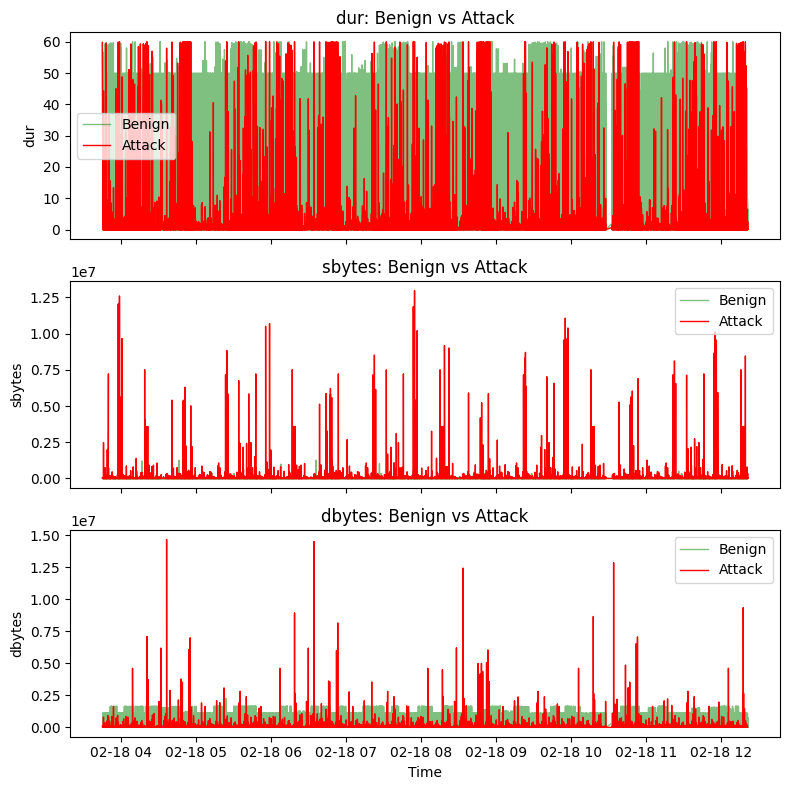

In [2]:
a_df = df[df['Label'] != 0]
b_df = df[df['Label'] == 0]
features = ['dur', 'sbytes', 'dbytes']
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i, col in enumerate(features):
    axs[i].plot(b_df.index, b_df[col], color='green', linewidth=1, alpha=0.5, label='Benign')
    axs[i].plot(a_df.index, a_df[col], color='red', linewidth=1, label='Attack')
    axs[i].set_title(f'{col}: Benign vs Attack')
    axs[i].set_ylabel(col)
    axs[i].legend()
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Aggregate the data by 1 second. To decide the label for that time window, I chose to calculate the `mode` for that window

Then, fill empty timestamps with 0

- Blue: Benign
- Red: Attack

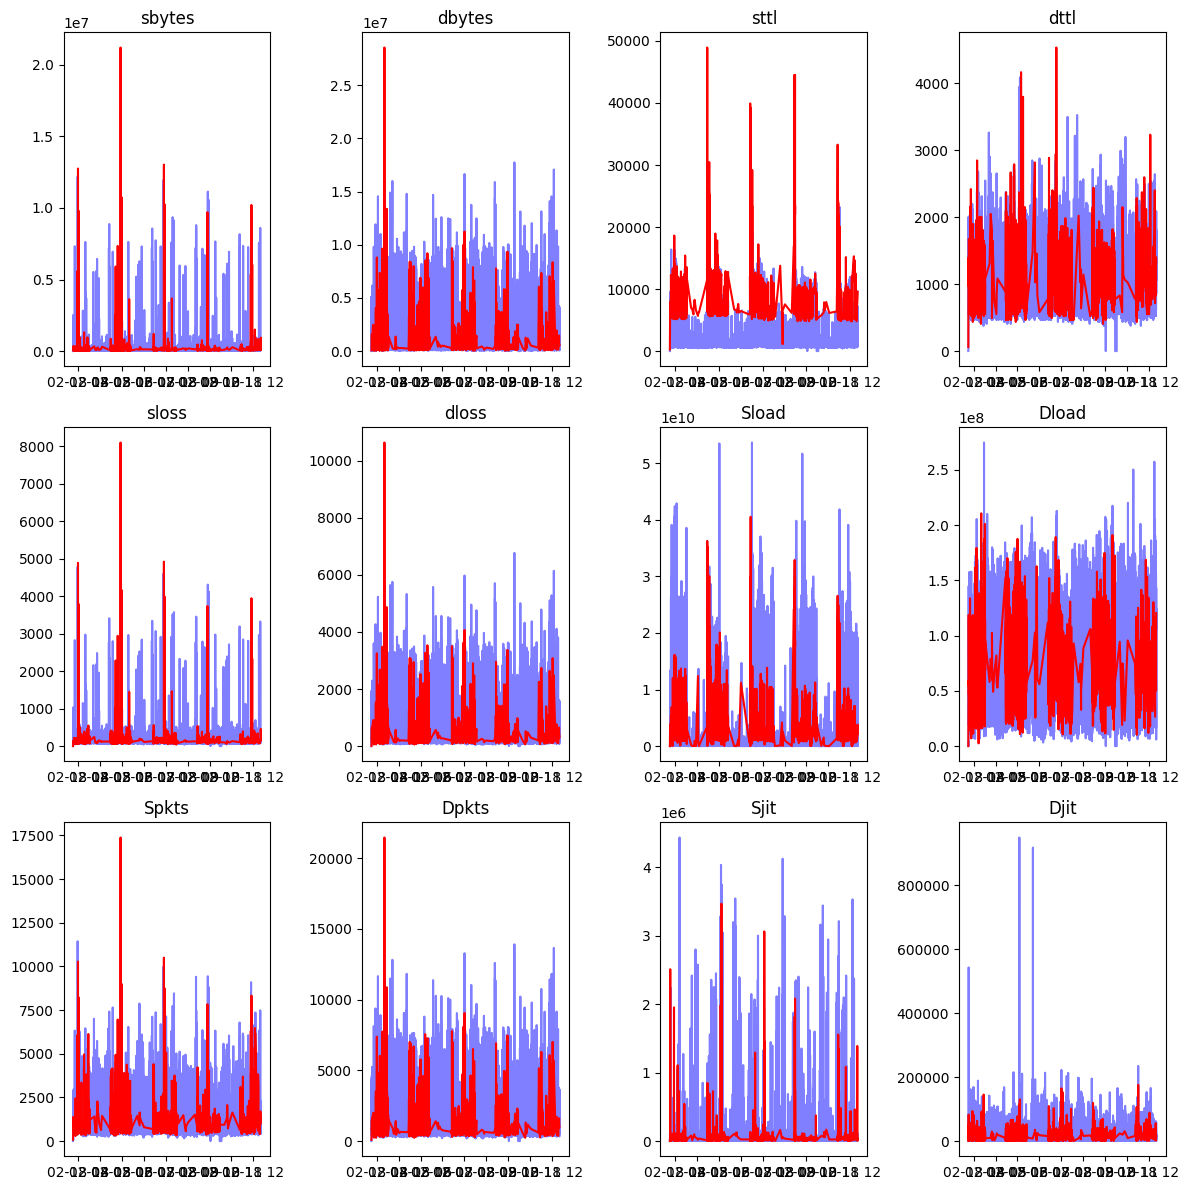

In [3]:
agg_df = df.resample('1s').agg(
    dur=('dur', 'sum'),
    sbytes=('sbytes', 'sum'),
    dbytes=('dbytes', 'sum'),
    sttl=('sttl', 'sum'),
    dttl=('dttl', 'sum'),
    sloss=('sloss', 'sum'),
    dloss=('dloss', 'sum'),
    Sload=('Sload', 'sum'),
    Dload=('Dload', 'sum'),
    Spkts=('Spkts', 'sum'),
    Dpkts=('Dpkts', 'sum'),
    Sjit=('Sjit', 'sum'),
    Djit=('Djit', 'sum'),
    label=('Label', lambda x: stats.mode(x)[0]),
)

agg_df.fillna(0, inplace=True)
a_agg = agg_df[agg_df['label'] == 1]
b_agg = agg_df[agg_df['label'] == 0]
atts = ['sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
    'Sload', 'Dload', 'Spkts', 'Dpkts', 'Sjit', 'Djit']
fig, axes = plt.subplots(3, 4, figsize=(12, 12))
for i, attr in enumerate(atts):
    row, col = divmod(i, 4)
    axes[row, col].plot(b_agg.index, b_agg[attr], color='blue', alpha=0.5)
    axes[row, col].plot(a_agg.index, a_agg[attr], color='red')
    axes[row, col].set_title(attr)
plt.tight_layout()
plt.show()

## Determining distance for DBSCAN

We can visualize the distances between points after scaling to help us determine `eps`

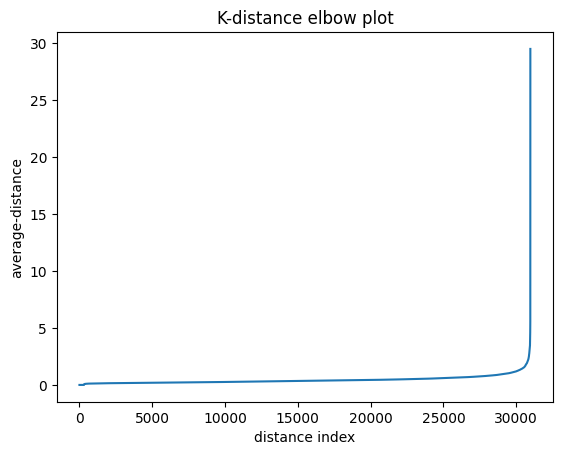

In [4]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(agg_df[atts])

neighbors = NearestNeighbors()
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)
plt.xlabel('distance index')
plt.ylabel('average-distance')
plt.title('K-distance elbow plot')
plt.show()


## Visualizing the effect of different filters
IsolationForest is an anomaly detection classifier, works well in this context

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (30970, 12)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()



/Users/jason.wong/PycharmProjects/NB15/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


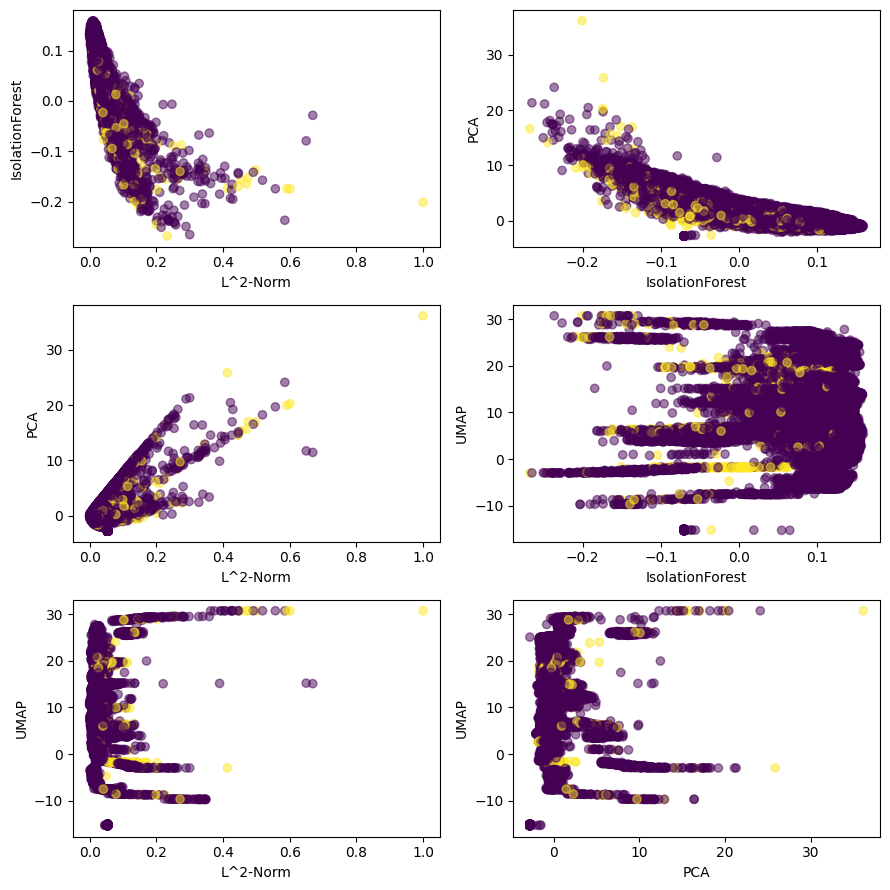

In [5]:
mapper = km.KeplerMapper(verbose=1)
lens1 = mapper.fit_transform(df_scaled, projection='l2norm')

projector = ensemble.IsolationForest()
projector.fit(df_scaled)
lens2 = projector.decision_function(df_scaled)

pca = PCA(n_components=1)
lens3 = pca.fit_transform(df_scaled)

umap_model = umap.UMAP(n_components=1, random_state=42)
umap_model.fit(df_scaled)
lens4 = umap_model.transform(df_scaled)

fig, axs = plt.subplots(3, 2, figsize=(9,9))
axs[0,0].scatter(lens1,lens2,c=agg_df['label'],alpha=0.5)
axs[0,0].set_xlabel('L^2-Norm')
axs[0,0].set_ylabel('IsolationForest')
axs[1,0].scatter(lens1,lens3,c=agg_df['label'],alpha=0.5)
axs[1,0].set_xlabel('L^2-Norm')
axs[1,0].set_ylabel('PCA')
axs[2,0].scatter(lens1,lens4,c=agg_df['label'],alpha=0.5)
axs[2,0].set_xlabel('L^2-Norm')
axs[2,0].set_ylabel('UMAP')
axs[0,1].scatter(lens2,lens3,c=agg_df['label'],alpha=0.5)
axs[0,1].set_xlabel('IsolationForest')
axs[0,1].set_ylabel('PCA')
axs[1,1].scatter(lens2,lens4,c=agg_df['label'],alpha=0.5)
axs[1,1].set_xlabel('IsolationForest')
axs[1,1].set_ylabel('UMAP')
axs[2,1].scatter(lens3,lens4,c=agg_df['label'],alpha=0.5)
axs[2,1].set_xlabel('PCA')
axs[2,1].set_ylabel('UMAP')
plt.tight_layout()
plt.show()



## Running Mapper
DBScan with  0.5 <= eps <= 1.0 works well

In [14]:
## Mapper
lens = np.c_[lens1, lens2]
cover = Cover(n_cubes=20, perc_overlap=0.20)
clusterer = DBSCAN(eps=0.5, min_samples=5)

G = mapper.map(
    lens,
    df_scaled,
    cover=cover,
    clusterer=clusterer,
)

_ = mapper.visualize(
    G,
    custom_tooltips=agg_df['label'].values,
    color_values=agg_df['label'].values,
    color_function_name="Label",
    path_html="mapper_unsw-nb15_agg.html",
    X=df_scaled,
    X_names=agg_df.columns[:-1].tolist(),
    lens=lens,
    lens_names=['L^2-Norm', 'IsolationForest']
)


Mapping on data shaped (30970, 12) using lens shaped (30970, 2)

Creating 400 hypercubes.

Created 101 edges and 177 nodes in 0:00:00.599379.
Wrote visualization to: mapper_unsw-nb15_agg.html


![](mapper.png)

## Persistent Homology
First transform to point cloud in 3-dimensional with Takens embedding.
Then run persistent homology on the point cloud

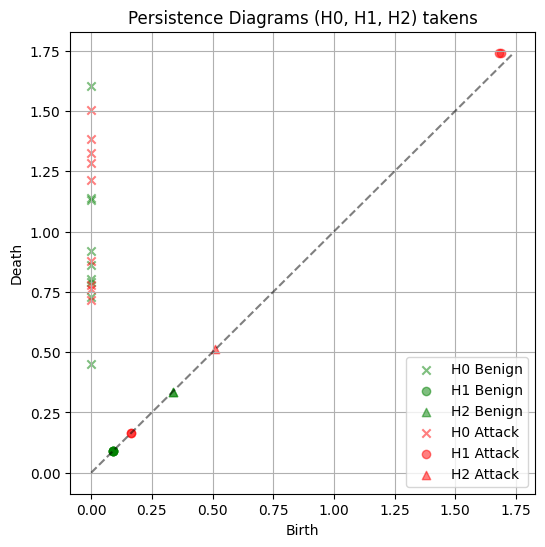

In [ ]:
dim = len(atts)

b_sliced = b_agg[atts].iloc[:int(b_agg.index.size)]
a_sliced = a_agg[atts].iloc[:int(a_agg.index.size)]

b_scaled = scaler.fit_transform(b_sliced)
b_scaled = pd.DataFrame(b_scaled, index=b_sliced.index, columns=atts)
a_scaled = scaler.fit_transform(a_sliced)
a_scaled = pd.DataFrame(a_scaled, index=a_sliced.index, columns=atts)

te = TakensEmbedding(time_delay=1, dimension=3)
b_embeddings = te.fit_transform(b_scaled)
a_embeddings = te.fit_transform(a_scaled)

## use if dimension=dim
# b_embeddings = b_embeddings.reshape(b_scaled.index.size, dim)[None, :, :]
# a_embeddings = a_embeddings.reshape(a_scaled.index.size, dim)[None, :, :]

ph = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
b_diagrams = ph.fit_transform(b_embeddings)
a_diagrams = ph.fit_transform(a_embeddings)

markers = {0: 'x', 1: 'o', 2: '^'}
labels = {0: 'H0', 1: 'H1', 2: 'H2'}
max_death = 0

fig = plt.subplots(figsize=(6, 6))
for d in [0,1,2]:
    dgm = b_diagrams[0][b_diagrams[0][:, 2] == d]
    if len(dgm) > 0:
        plt.scatter(dgm[:, 0], dgm[:, 1], c='green', marker=markers[d],
                    label=f'{labels[d]} Benign', alpha=0.5)
        max_death = max(max_death, max(dgm[:, 1]))

for d in [0,1,2]:
    dgm = a_diagrams[0][a_diagrams[0][:, 2] == d]
    if len(dgm) > 0:
        plt.scatter(dgm[:, 0], dgm[:, 1], c='red', marker=markers[d],
                    label=f'{labels[d]} Attack', alpha=0.5)
        max_death = max(max_death, max(dgm[:, 1]))

plt.plot([0, max_death], [0, max_death], 'k--', alpha=0.5)
plt.xlabel('Birth')
plt.ylabel('Death')
plt.title('Persistence Diagrams (H0, H1, H2) takens')
plt.legend()
plt.grid(True)
plt.show()



## Interpretation
The attack time series exhibit higher persistence than benign time series

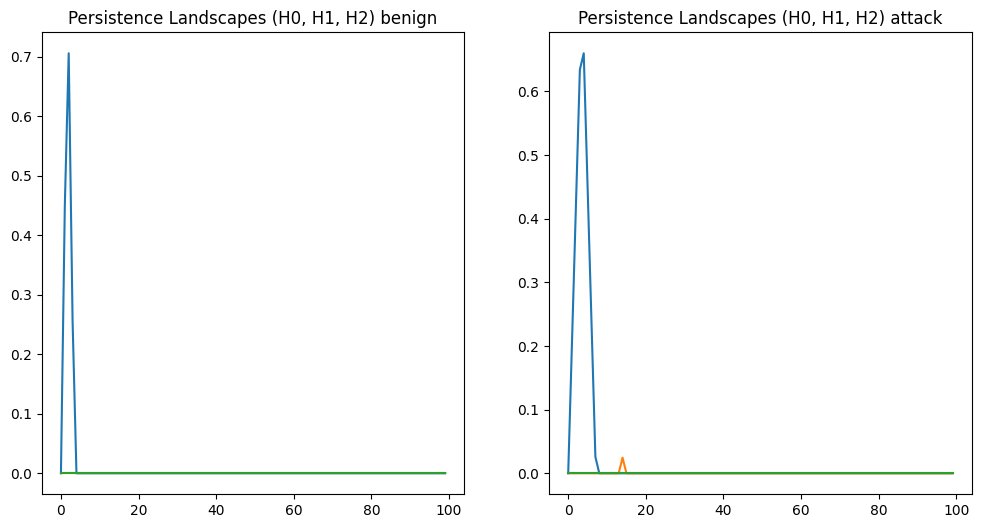

In [ ]:
pl = PersistenceLandscape()
b_ls = pl.fit_transform(b_diagrams)
a_ls = pl.fit_transform(a_diagrams)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i in range(b_ls.shape[1]):
    ax[0].plot(b_ls[0, i], label=f'Benign')
    ax[0].set_title('Persistence Landscapes (H0, H1, H2) benign')
for i in range(a_ls.shape[1]):
    ax[1].plot(a_ls[0, i], label=f'Attack')
    ax[1].set_title('Persistence Landscapes (H0, H1, H2) attack')
plt.show()


## Euler Characteristic Profiles with 2-parameter filtration

In [9]:
from eulearning.utils import vectorize_st, codensity
from eulearning.descriptors import RadonTransform, EulerCharacteristicProfile
from gtda.time_series import SingleTakensEmbedding
import gudhi as gd

te = TakensEmbedding(time_delay=1, dimension=3)
b_embeddings = te.fit_transform(b_scaled)
a_embeddings = te.fit_transform(a_scaled)

b_vec_sts = []
for i in range(b_embeddings.shape[0]):
    b_point_cloud = b_embeddings[i]
    b_ac = gd.AlphaComplex(points=b_point_cloud)
    b_st = b_ac.create_simplex_tree()
    X_ = np.array([b_ac.get_point(i) for i in range(b_st.num_vertices())])
    b_codensity_filt = codensity(X_)
    b_vec_st = vectorize_st(b_st, filtrations=[b_codensity_filt])
    b_vec_sts.append(b_vec_st)

a_vec_sts = []
for i in range(a_embeddings.shape[0]):
    a_point_cloud = a_embeddings[i]
    a_ac = gd.AlphaComplex(points=a_point_cloud)
    a_st = a_ac.create_simplex_tree()
    Y_ = np.array([a_ac.get_point(i) for i in range(a_st.num_vertices())])
    a_codensity_filt = codensity(Y_)
    a_vec_st = vectorize_st(a_st, filtrations=[a_codensity_filt])
    a_vec_sts.append(a_vec_st)

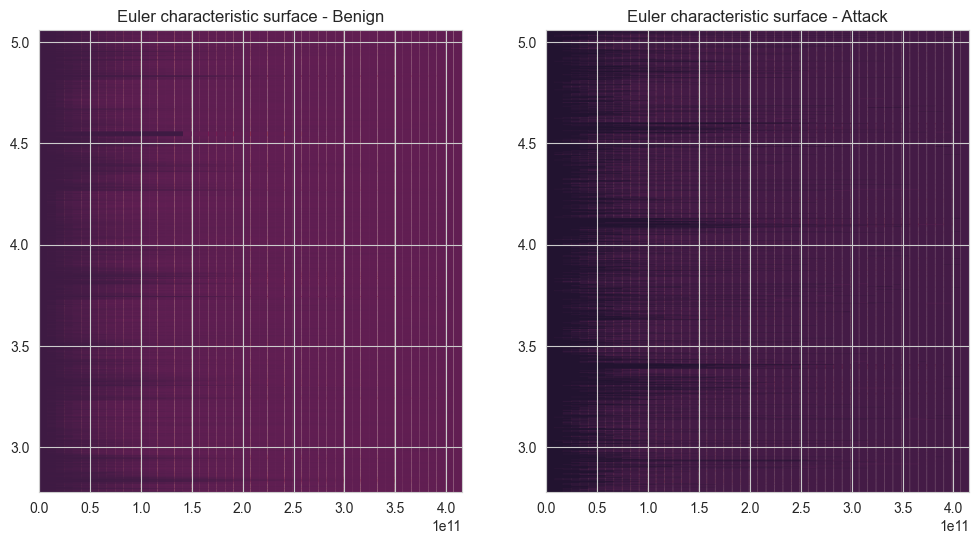

In [10]:
euler_profile = EulerCharacteristicProfile(resolution=(50,50), quantiles=[(0,1), (0,1)], pt_cld=True, normalize=False, flatten=True)
b_ecp = euler_profile.fit_transform(b_vec_sts)
a_ecp = euler_profile.fit_transform(a_vec_sts)
extent = list(euler_profile.val_ranges[0])+list(euler_profile.val_ranges[1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(b_ecp, origin='lower', extent=extent, aspect='auto')
ax[0].set_title('Euler characteristic surface - Benign')
ax[1].imshow(a_ecp, origin='lower', extent=extent, aspect='auto')
ax[1].set_title('Euler characteristic surface - Attack')
plt.show()


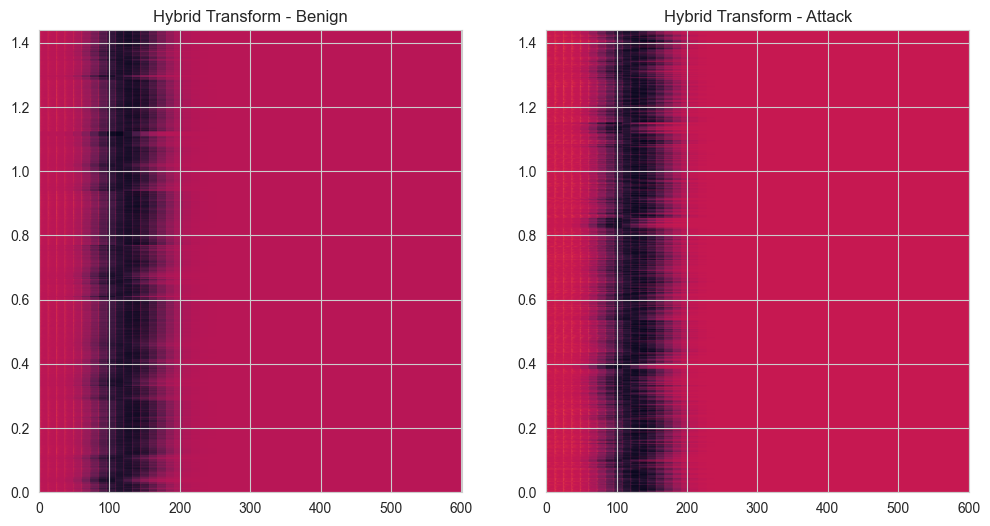

In [11]:
from eulearning.descriptors import HybridTransform

hybrid_transform = HybridTransform(resolution=(50,50), quantiles=[0.3, 0.2], kernel_name='wavelet_4', pt_cld=True, normalize=False, flatten=True)
b_ht = hybrid_transform.fit_transform(b_vec_sts)
a_ht = hybrid_transform.fit_transform(a_vec_sts)
extent = list(hybrid_transform.val_ranges[0])+list(hybrid_transform.val_ranges[1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(b_ht, origin='lower', extent=extent, aspect='auto')
ax[0].set_title('Hybrid Transform - Benign')
ax[1].imshow(a_ht, origin='lower', extent=extent, aspect='auto')
ax[1].set_title('Hybrid Transform - Attack')
plt.show()

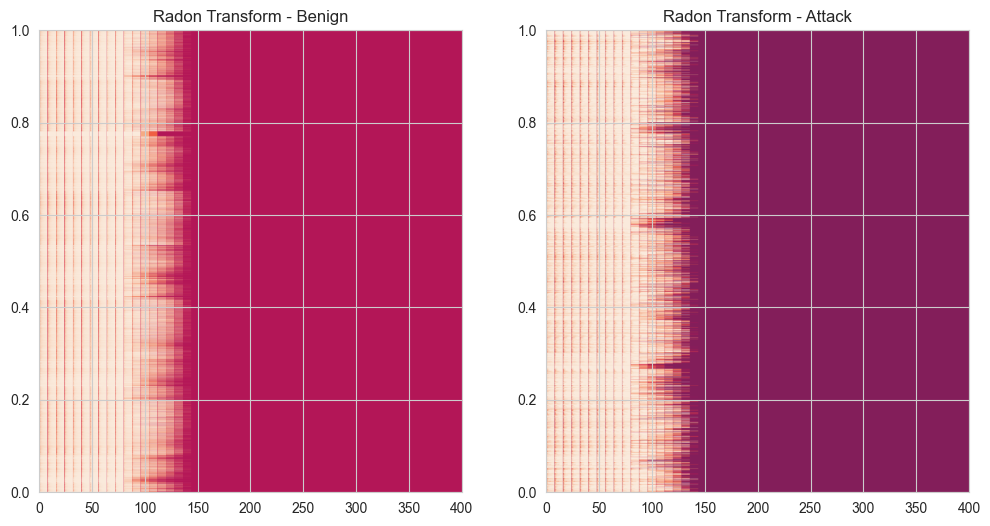

In [12]:
from eulearning.descriptors import RadonTransform

radon_transform = RadonTransform(resolution=(50,50), val_ranges=[(0, 400), (0, 1)], pt_cld=True, normalize=False, flatten=True)
b_rdn = radon_transform.fit_transform(b_vec_sts)
a_rdn = radon_transform.fit_transform(a_vec_sts)
extent = list(radon_transform.val_ranges[0])+list(radon_transform.val_ranges[1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(b_rdn, origin='lower', extent=extent, aspect='auto')
ax[0].set_title('Radon Transform - Benign')
ax[1].imshow(a_rdn, origin='lower', extent=extent, aspect='auto')
ax[1].set_title('Radon Transform - Attack')
plt.show()